# Project Setup

## Imports

In [4]:
import librosa
import numpy as np
import pandas as pd
import os
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm
import skl2onnx
import tensorflow as tf

sys.path.append(os.getcwd())

import python_utils

## Global Variables

In [20]:
PREPROCESSED_DATA_FILE = os.path.join("no_ground_hits", "preprocessed_data", "preprocessed_data_2025-03-17 12:04:55.941999.pkl")
TRAINED_MODELS_DIR = os.path.join("no_ground_hits", "trained_models")
TRAIN_PROPORTION = 0.66
RANDOM_SEED = 42
WINDOW_SIZE = 6616 # From preprocessing.ipynb
SAMPLE_RATE = 22050 # From preprocessing.ipynb

In [6]:
np.random.seed(RANDOM_SEED)

# Load Data

In [7]:
with open(PREPROCESSED_DATA_FILE, 'rb') as file:
    tracker = pickle.load(file)

print(tracker.keys())
python_utils.custom_print(tracker)

dict_keys(['PXL_20250222_012947893.TS_1', 'PXL_20250223_164224211.TS_1', 'PXL_20250222_012947893.TS_2', 'PXL_20250222_013140200.TS_1', 'PXL_20250223_164321190.TS_1', 'PXL_20250223_164250127.TS_1'])
{
  'PXL_20250222_012947893.TS_1': {
    'x': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         7.3242560e-04,  7.0753385e-04,  7.3038030e-04],
       [ 6.8282022e-04,  6.7373691e-04,  4.2436406e-04, ...,
         1.0909824e-04,  1.5050969e-03,  2.6611104e-03],
       [ 3.4842943e-03,  3.9587440e-03,  4.0320847e-03, ...,
        -4.6930549e-04, -8.7165259e-05,  2.9021440e-04],
       ...,
       [-2.3366683e-03, -1.2868965e-03, -4.8474519e-04, ...,
         2.3729303e-03,  2.8112328e-03,  2.3666527e-03],
       [ 8.1231265e-04, -7.0396642e-04, -1.4670453e-03, ...,
        -2.5612016e-03, -2.3966371e-03, -1.1908840e-03],
       [ 1.4526818e-03,  4.1987905e-03,  6.5072370e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
    'x_spectrogram':

# Preprocess
* Audio data are transformed into decible spectograms (2D arrays)

In [ ]:
def transform_audio_to_spectrogram(audio_values: np.array, top_db: float = 75.0) -> np.array:
    """Transform audio values into a magnitude spectrogram in decibels,
       ensuring the output has the same number of time frames as the input.
    """
    audio_stft = librosa.stft(
        y=audio_values,
        # n_fft=audio_values.shape[0] / ,
    )
    audio_abs = np.abs(audio_stft)
    audio_db = librosa.amplitude_to_db(audio_abs, top_db=top_db)
    return audio_db


def transform_audio_to_mel_spectrogram(audio_values: np.array, sr: int, n_mels: int = 128, top_db: float = 80.0) -> np.array:
    """Transform audio values into a Mel spectrogram in decibels.

    Args:
        audio_values: The audio waveform as a NumPy array.
        sr: The sampling rate of the audio.
        n_mels: The number of Mel bands to use.
        top_db: The maximum decibel value to use.

    Returns:
        The Mel spectrogram as a NumPy array.
    """
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_values, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spectrogram, top_db=top_db)
    return mel_db

In [27]:
for base_name in tracker:
  tracker[base_name]["x_spectrogram"] = np.array([transform_audio_to_mel_spectrogram(
      audio_values=tracker[base_name]["x"][i],
      sr=SAMPLE_RATE,
      n_mels=256,  # Changed to 256 for more resolution
  ) for i in range(len(tracker[base_name]["x"]))])

In [28]:
for base_name in tracker:
    print(base_name)
    print(tracker[base_name]["x_spectrogram"].shape)

PXL_20250222_012947893.TS_1
(60, 256, 13)
PXL_20250223_164224211.TS_1
(104, 256, 13)
PXL_20250222_012947893.TS_2
(92, 256, 13)
PXL_20250222_013140200.TS_1
(530, 256, 13)
PXL_20250223_164321190.TS_1
(176, 256, 13)
PXL_20250223_164250127.TS_1
(80, 256, 13)


Index: 1
Has Juggle: False


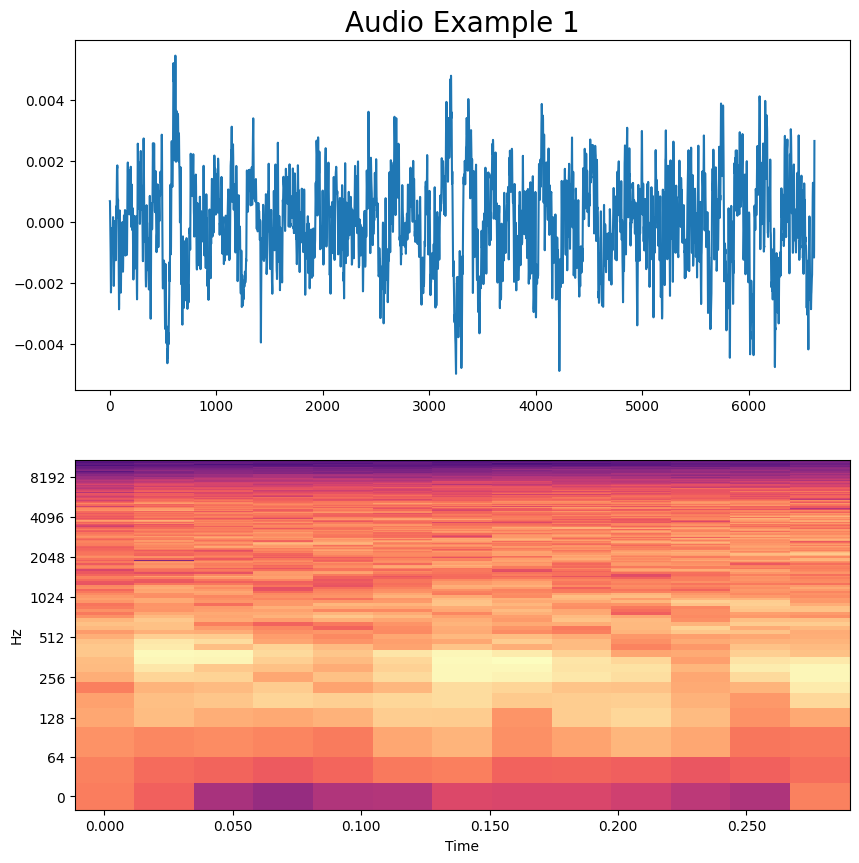

Index: 59
Has Juggle: False


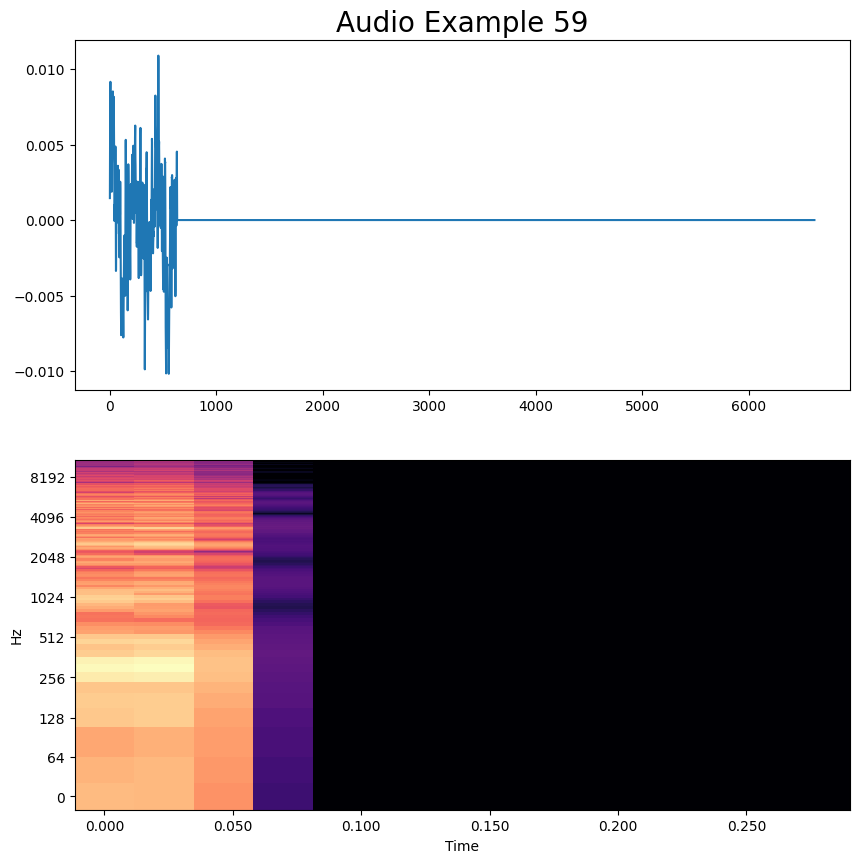

Index: 20
Has Juggle: False


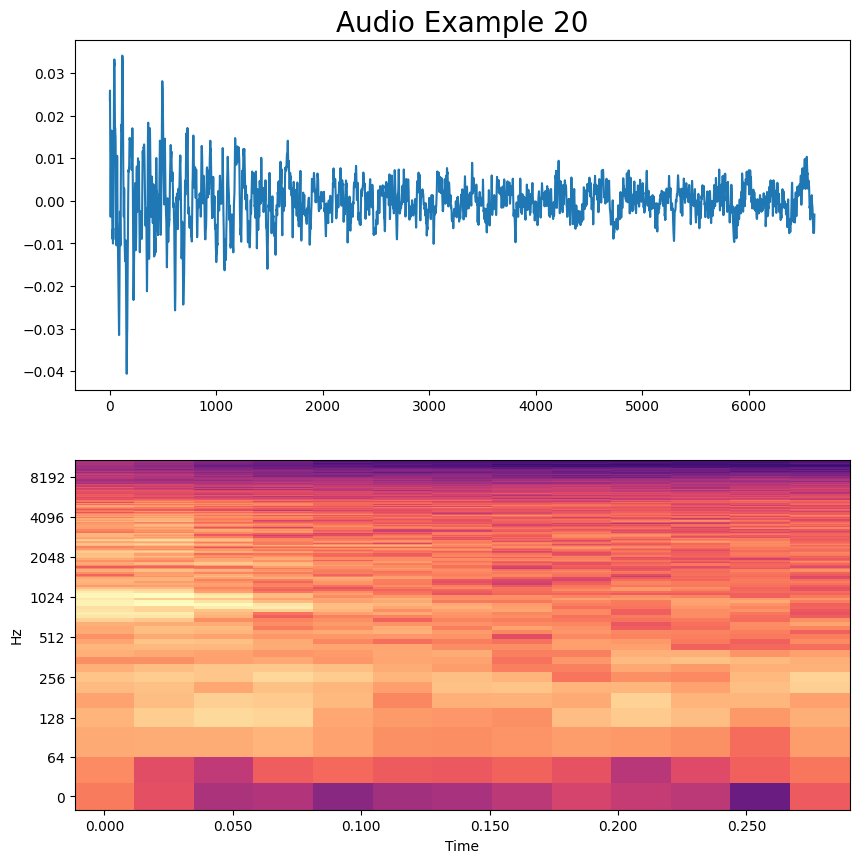

Index: 32
Has Juggle: False


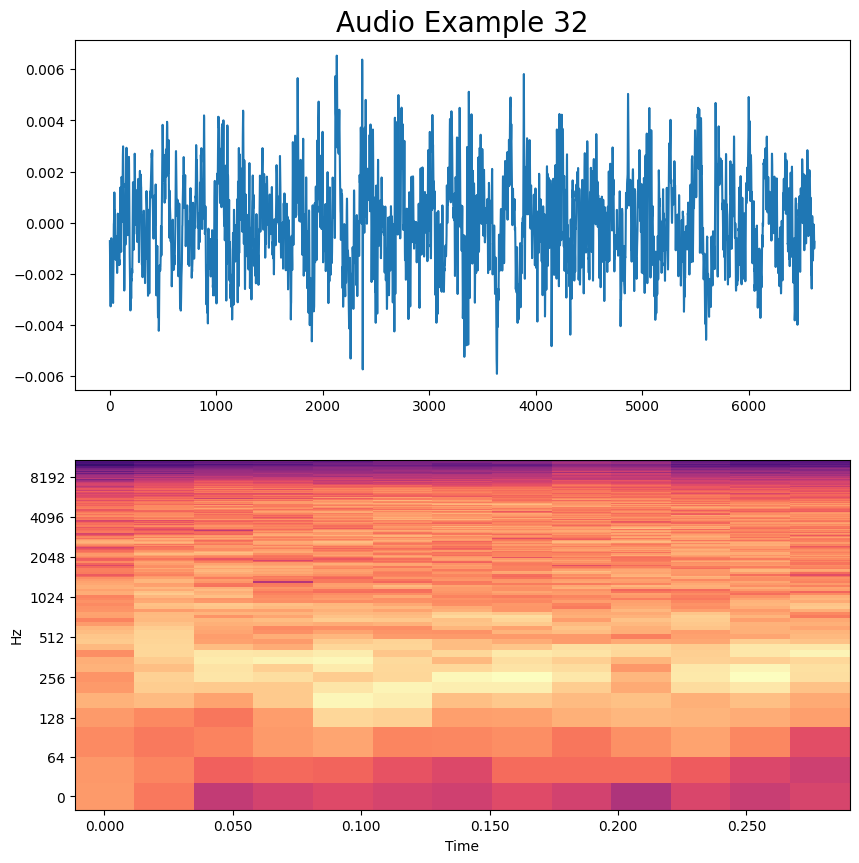

Index: 11
Has Juggle: True


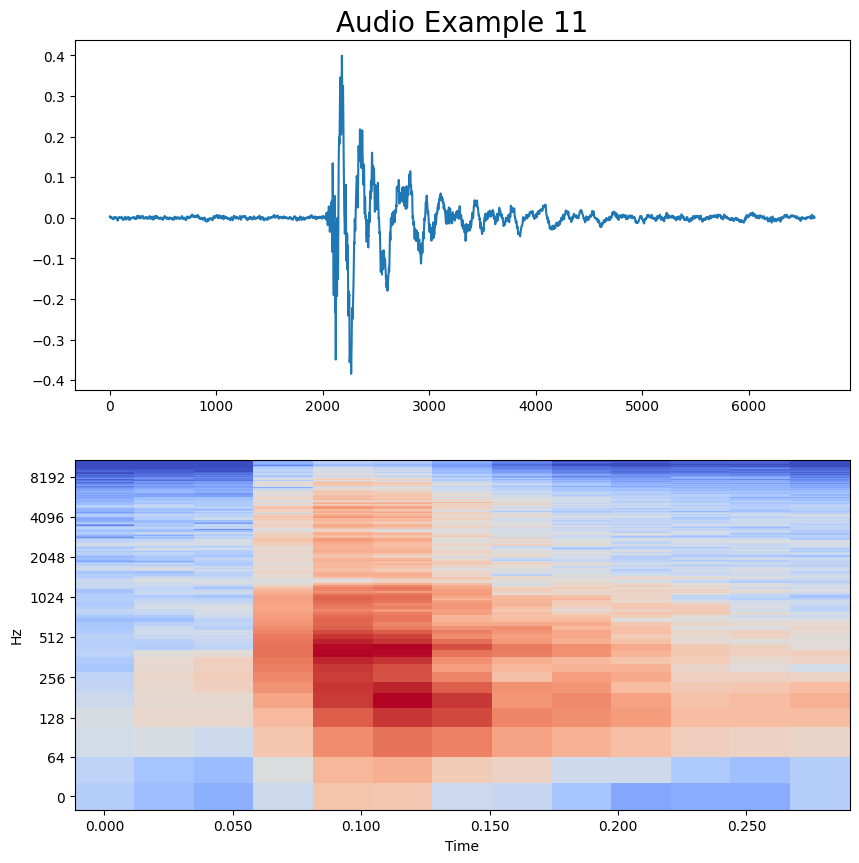

In [29]:
example = "PXL_20250222_012947893.TS_1"
# i = 2

for i in np.random.choice(
    a=list(range(tracker[example]["y"].shape[0])),
    size=5,
):
    print("Index:", i)
    print("Has Juggle:", tracker[example]["y"][i] == 1)
    # Plot the original audio data
    fig, ax = plt.subplots(figsize=(10, 10), ncols=1, nrows=2)
    ax[0].plot(tracker[example]["x"][i])
    ax[0].set_title(f'Audio Example {i}', fontsize=20)
    # Plot the transformed audio data
    img = librosa.display.specshow(tracker[example]["x_spectrogram"][i],
                                x_axis='time',
                                y_axis='log',
                                ax=ax[1])
    # ax.set_title('Spectogram Example', fontsize=20)
    # fig.colorbar(img, ax=ax[1], format=f'%0.2f')
    plt.show()

# Train, Test Split
Split on datafile; use data for testing that is in files that were not used for training.

In [30]:
files_list = list(tracker.keys())
np.random.shuffle(files_list)
train_files = files_list[:int(round(TRAIN_PROPORTION * len(files_list)))]
test_files = files_list[int(round(TRAIN_PROPORTION * len(files_list))):]

train_test = {
    "train": {
        "files": train_files,
        "x": list(),
        "x_spectrogram": list(),
        "y": list(),
    },
    "test": {
        "files": test_files,
        "x": list(),
        "x_spectrogram": list(),
        "y": list(),
    },
}

for base_name in files_list:
  for i in range(len(tracker[base_name]["x"])):
    if base_name in train_test["train"]["files"]:
      train_test["train"]["x"].append(tracker[base_name]["x"][i])
      train_test["train"]["x_spectrogram"].append(tracker[base_name]["x_spectrogram"][i])
      train_test["train"]["y"].append(tracker[base_name]["y"][i])
    else:
      train_test["test"]["x"].append(tracker[base_name]["x"][i])
      train_test["test"]["x_spectrogram"].append(tracker[base_name]["x_spectrogram"][i])
      train_test["test"]["y"].append(tracker[base_name]["y"][i])

for train_or_test in train_test:
  for x_or_y in ["x", "y"]:
    train_test[train_or_test][x_or_y] = np.array(train_test[train_or_test][x_or_y])

python_utils.custom_print(train_test)

{
  'train': {
    'files': ['PXL_20250223_164250127.TS_1', 'PXL_20250222_012947893.TS_2', 'PXL_20250222_012947893.TS_1', 'PXL_20250222_013140200.TS_1']
    'x': array([[ 0.        ,  0.        ,  0.        , ...,  0.000471  ,
         0.00062051,  0.00066932],
       [ 0.00068211,  0.00093359,  0.00163902, ..., -0.00327503,
        -0.00450281, -0.00392979],
       [-0.00350203, -0.003466  , -0.0038958 , ..., -0.00294802,
        -0.00221975, -0.00409448],
       ...,
       [ 0.0123065 ,  0.01335477,  0.01538756, ...,  0.00549763,
         0.00700623,  0.00813506],
       [ 0.00842734,  0.00874328,  0.00858792, ..., -0.00432418,
        -0.00476446, -0.00582592],
       [-0.00709299, -0.00730564, -0.00704636, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)
    'x_spectrogram': [array([[-88.60769 , -88.60769 , -88.60769 , ..., -32.784943, -40.741158,
        -36.0773  ],
       [-88.60769 , -88.60769 , -88.60769 , ..., -31.367756, -31.948528,
        -34.2647  ],


# Train Model

In [13]:
models = dict()

## Suport Vector Machine

In [14]:
models["SVM"] = dict()
models["SVM"]["model"] = svm.SVC()
models["SVM"]["model"].fit(train_test["train"]["x"], train_test["train"]["y"])
models["SVM"]["y_pred"] = models["SVM"]["model"].predict(train_test["test"]["x"])
models["SVM"]["accuracy"] = metrics.accuracy_score(
    train_test["test"]["y"],
    models["SVM"]["y_pred"],
)

## CNN

In [ ]:
def create_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape[0], input_shape[1], 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification, so sigmoid output
    ])
    return model

In [31]:
models["CNN"] = dict()
models["CNN"]["model"] = create_cnn_model((256, 13))
models["CNN"]["model"].compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
models["CNN"]["model"].fit(np.array(train_test["train"]["x_spectrogram"]), train_test["train"]["y"], epochs=10)
models["CNN"]["y_pred"] = models["CNN"]["model"].predict(np.array(train_test["test"]["x_spectrogram"]))
models["CNN"]["y_pred"] = (models["CNN"]["y_pred"] > 0.5).astype(int)
models["CNN"]["accuracy"] = metrics.accuracy_score(
    train_test["test"]["y"],
    models["CNN"]["y_pred"],
)

Epoch 1/10


/home/colin/code/bat_jester_model_training/.devenv/state/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5069 - loss: 6.5716
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5215 - loss: 0.6856
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6579 - loss: 0.6663
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6517 - loss: 0.6529
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6189 - loss: 0.6218
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.6232 - loss: 0.6555
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6619 - loss: 0.6045
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6963 - loss: 0.5868
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6284 - loss: 0.6471
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6746 - loss: 0.5840
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


# Evaluate Models

## Accuracy

In [32]:
for model in models:
  print(f"{model}: {models[model]['accuracy']}")

SVM: 0.85546875
CNN: 0.7392857142857143


## Visualize Predictions

In [15]:
NUM_VISUALIZATIONS = 10

In [16]:
def plot_examples(x_test, y_test, models, indices_to_plot, num_visualizations, ylim = 0.5):
  num_plots = min(len(indices_to_plot), num_visualizations)
  fig, ax = plt.subplots(
      figsize=(10, 30),
      nrows=num_plots,
      ncols=1,
  )
  for i in range(num_plots):
    pd.Series(x_test[indices_to_plot[i]]).plot(
        lw=1,
        color='blue',
        ax=ax[i],
        label=f"Actual: {y_test[indices_to_plot[i]]}, Predictions: " + str([f"{model}: {models[model]['y_pred'][indices_to_plot[i]]}" for model in models]),
    )
    ax[i].legend()
    ax[i].set_ylim(-ylim, ylim)
  plt.show()

## Random Sample

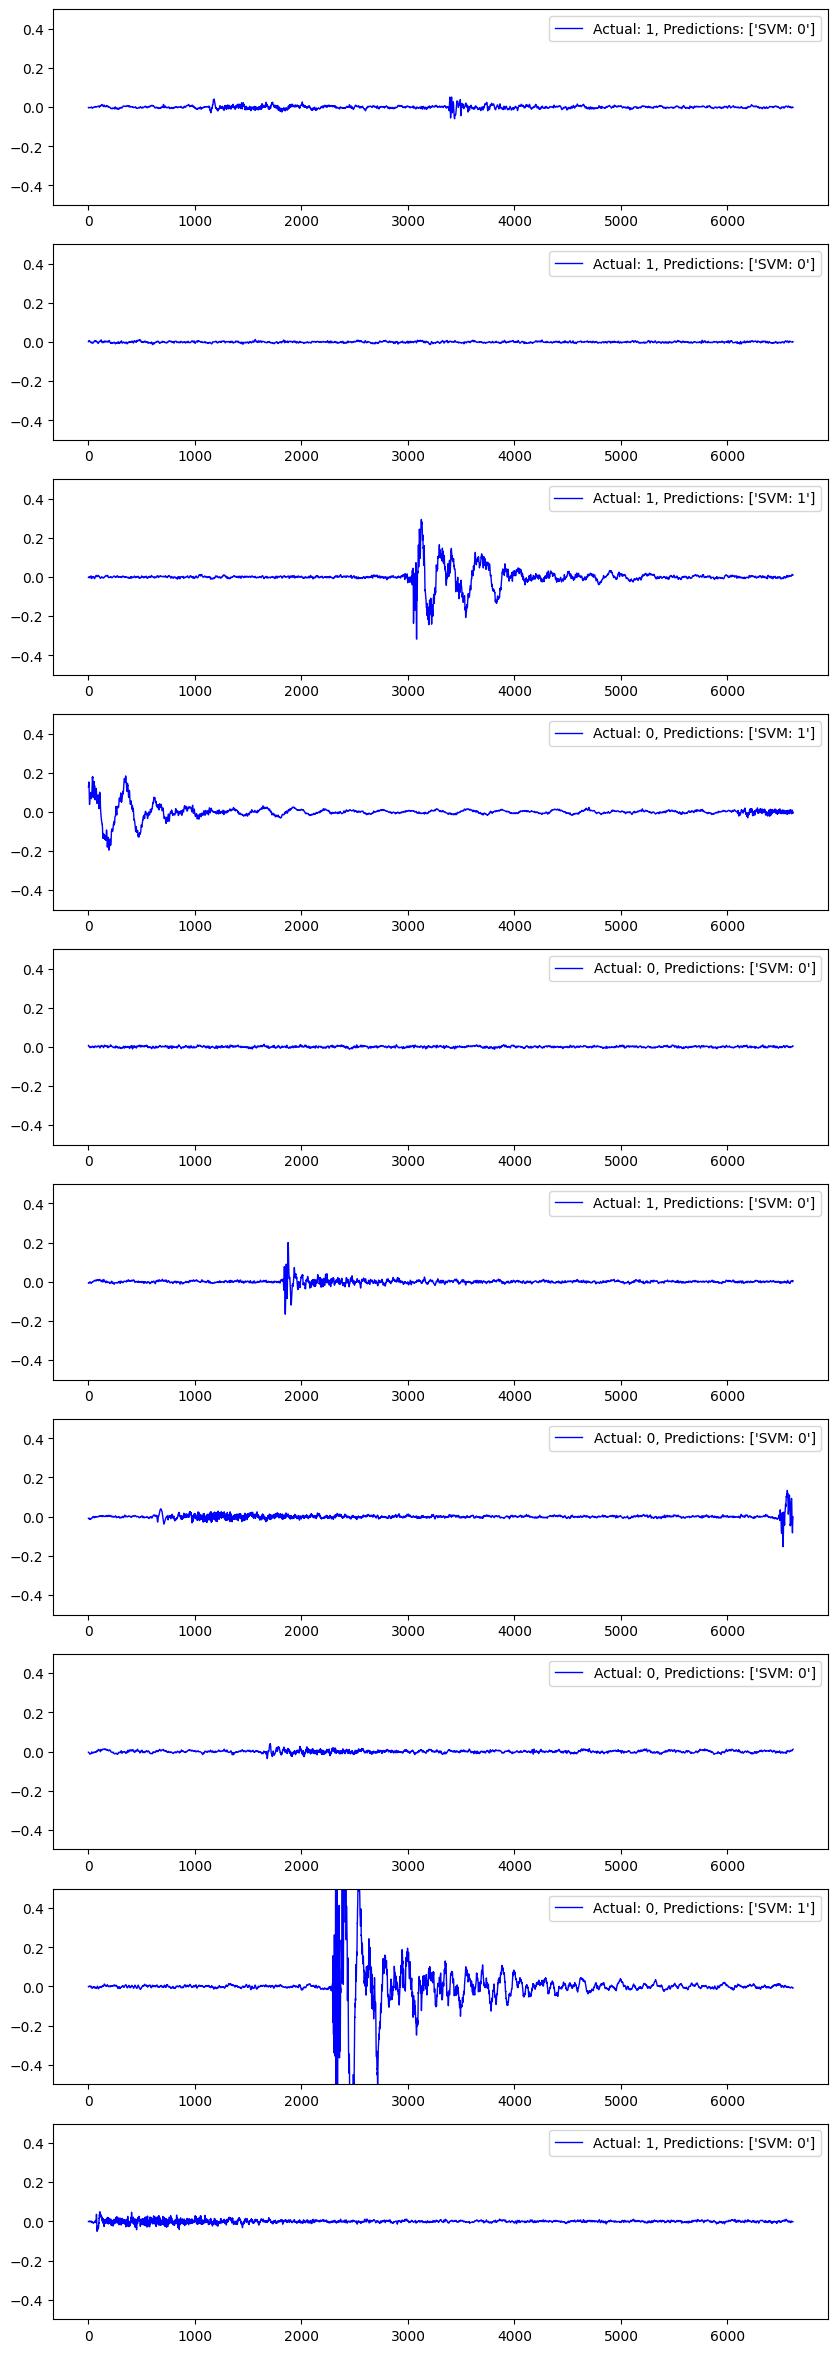

In [17]:
random_indices = np.random.choice(
    train_test["test"]["x"].shape[0],
    NUM_VISUALIZATIONS,
    replace=False,
    )

plot_examples(
    x_test=train_test["test"]["x"],
    y_test=train_test["test"]["y"],
    models=models,
    indices_to_plot=random_indices,
    num_visualizations=NUM_VISUALIZATIONS,
)

## Incorrect Predictions

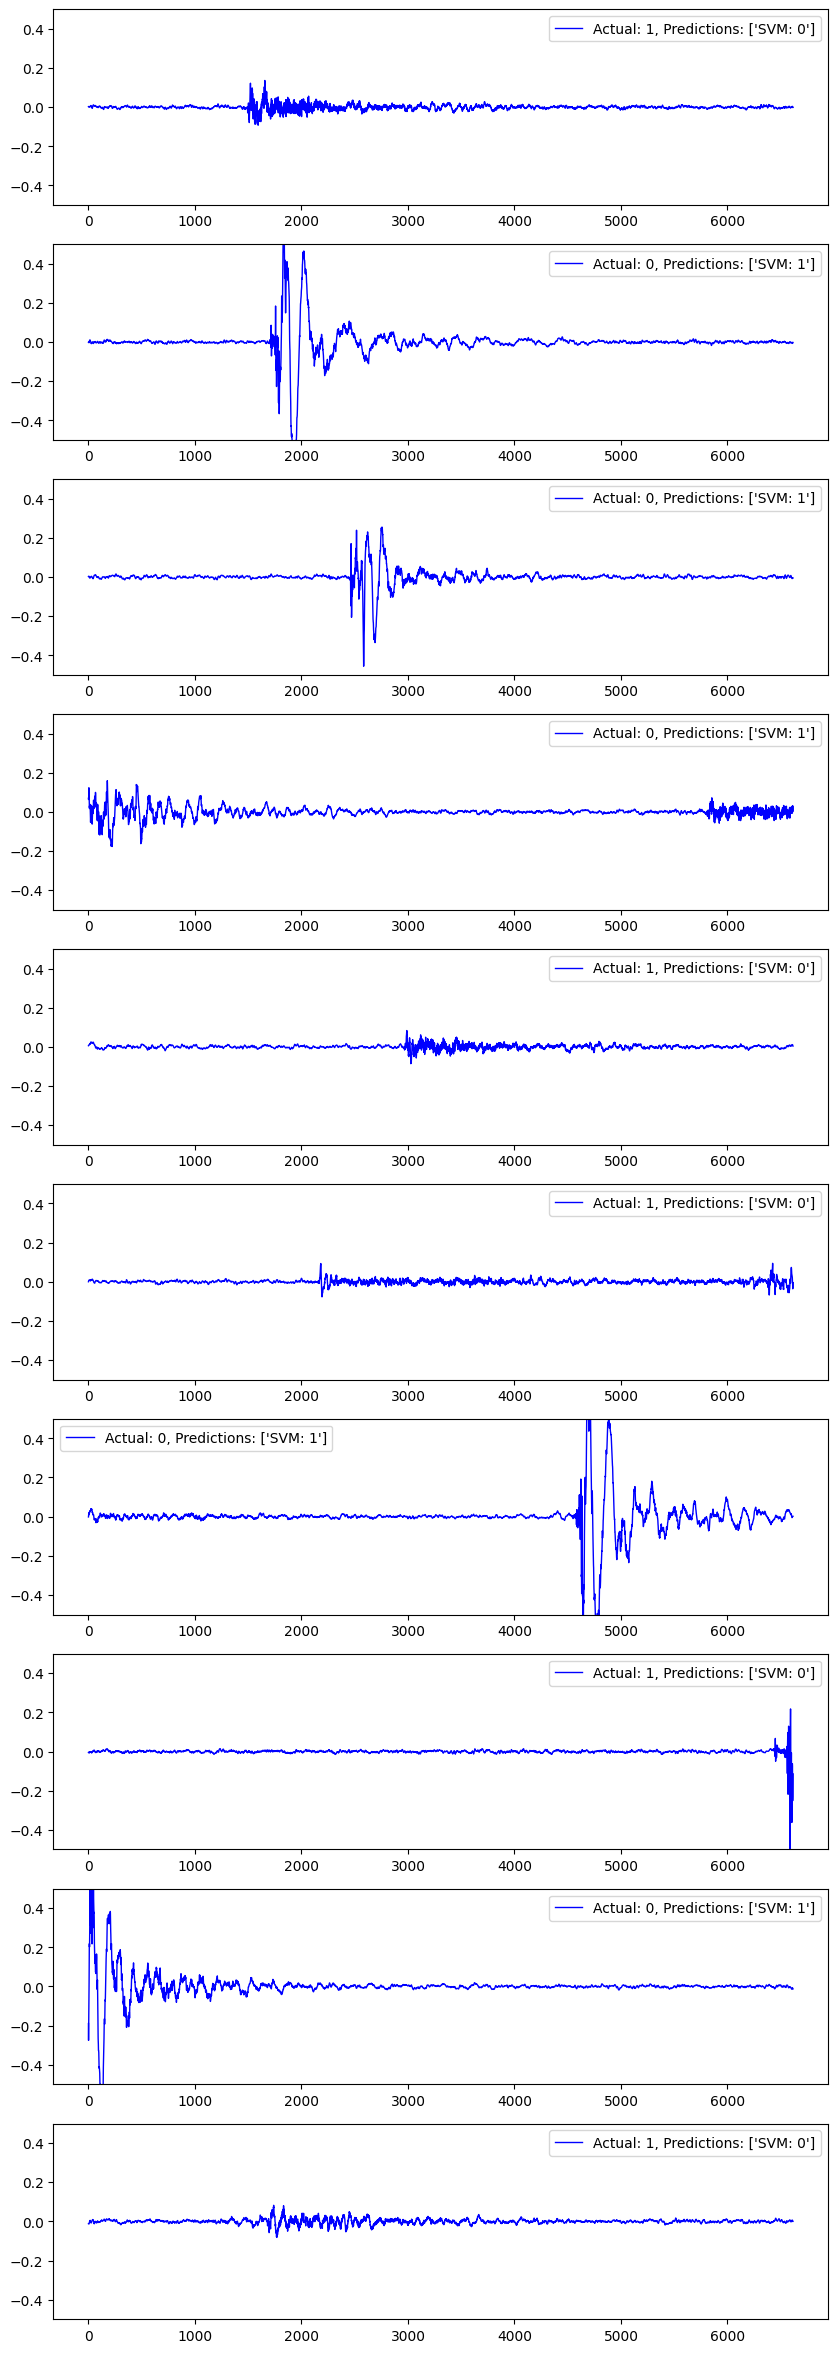

In [18]:
for model in models:
  models[model]["incorrect_indices"] = np.where(train_test["test"]["y"] != models[model]["y_pred"])[0]

plot_examples(
    x_test=train_test["test"]["x"],
    y_test=train_test["test"]["y"],
    models=models,
    indices_to_plot=models["SVM"]["incorrect_indices"],
    num_visualizations=NUM_VISUALIZATIONS,
)

# Save Models for Deployment

In [21]:
# Convert the model to ONNX
initial_type = [('float_input', skl2onnx.common.data_types.FloatTensorType([None, train_test["train"]["x"][0].shape[0]])) ] #Replace X.shape[1] with the correct shape.
onnx_model = skl2onnx.convert_sklearn(models["SVM"]["model"], initial_types=initial_type)

# Save the ONNX model
with open(os.path.join(TRAINED_MODELS_DIR, f'model_svm_{pd.Timestamp.now()}.onnx'), 'wb') as f:
    f.write(onnx_model.SerializeToString())